In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Change this to your actual ZIP file name inside FDIPproject
zip_path = "/content/drive/MyDrive/FDIPproject/archive (3).zip"

# Unzip into /content/dataset
import zipfile, os
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Check extracted folders
!ls /content/dataset


Mounted at /content/drive
test  train  valid


In [2]:
# Install PyTorch, torchvision, timm (for advanced models, optional)
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # remove limitation for large images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

!pip install torch torchvision timm --quiet

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# -------------------------------
# Image preprocessing / augmentation
# -------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),      # Random horizontal flip
    transforms.RandomRotation(15),          # Random rotation
    transforms.ToTensor(),                  # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406],   # Normalize using ImageNet stats
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# -------------------------------
# Load datasets
# -------------------------------
train_dataset = datasets.ImageFolder(root="/content/dataset/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root="/content/dataset/valid", transform=val_transforms)
test_dataset  = datasets.ImageFolder(root="/content/dataset/test", transform=val_transforms)

# -------------------------------
# Data loaders
# -------------------------------
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# -------------------------------
# Check class names
# -------------------------------
print("Classes:", train_dataset.classes)


Classes: ['nowildfire', 'wildfire']


In [4]:
import torch
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pretrained ResNet18
model = models.resnet18(pretrained=True)

# Replace the final fully connected layer to match our 2 classes (fire / no_fire)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 output classes

# Move model to GPU if available
model = model.to(device)

# Print model summary (optional)
print(model)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 105MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
import torch.optim as optim
import torch.nn as nn

# -------------------------------
# Loss function
# -------------------------------
# CrossEntropyLoss is standard for multi-class / binary classification
criterion = nn.CrossEntropyLoss()

# -------------------------------
# Optimizer
# -------------------------------
# Adam optimizer is efficient and widely used
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -------------------------------
# Learning rate scheduler (optional but recommended)
# -------------------------------
# StepLR reduces learning rate every few epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Loss function, optimizer, and scheduler are ready!")


Loss function, optimizer, and scheduler are ready!


In [6]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*30)

        # -------------------
        # Training phase
        # -------------------
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_loss)

        # -------------------
        # Validation phase
        # -------------------
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels)

        val_loss = running_loss / len(val_dataset)
        val_acc = running_corrects.double() / len(val_dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        # Deep copy the best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Step the scheduler
        scheduler.step()

    print(f"\nBest Validation Accuracy: {best_acc:.4f}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_accs

# -------------------
# Train the model
# -------------------
num_epochs = 10
model, train_losses, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
------------------------------
Train Loss: 0.0849 | Val Loss: 0.0486 | Val Acc: 0.9830
Epoch 2/10
------------------------------
Train Loss: 0.0459 | Val Loss: 0.0320 | Val Acc: 0.9897
Epoch 3/10
------------------------------
Train Loss: 0.0380 | Val Loss: 0.0319 | Val Acc: 0.9897
Epoch 4/10
------------------------------
Train Loss: 0.0303 | Val Loss: 0.0399 | Val Acc: 0.9878
Epoch 5/10
------------------------------
Train Loss: 0.0269 | Val Loss: 0.0616 | Val Acc: 0.9771
Epoch 6/10
------------------------------
Train Loss: 0.0133 | Val Loss: 0.0226 | Val Acc: 0.9929
Epoch 7/10
------------------------------
Train Loss: 0.0083 | Val Loss: 0.0178 | Val Acc: 0.9946
Epoch 8/10
------------------------------
Train Loss: 0.0073 | Val Loss: 0.0173 | Val Acc: 0.9940
Epoch 9/10
------------------------------
Train Loss: 0.0058 | Val Loss: 0.0181 | Val Acc: 0.9944
Epoch 10/10
------------------------------
Train Loss: 0.0045 | Val Loss: 0.0207 | Val Acc: 0.9937

Best Validation Ac

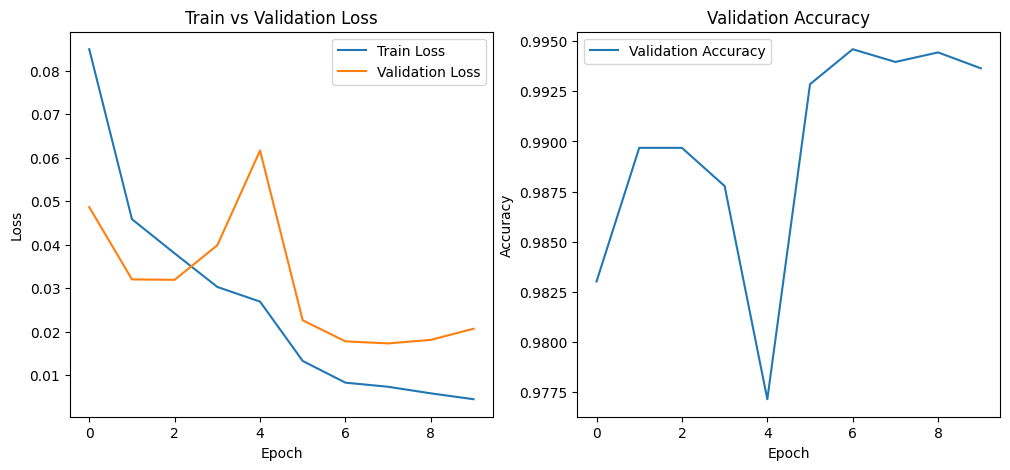

In [7]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()


In [8]:
model.eval()  # set model to evaluation mode
running_corrects = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels)

test_acc = running_corrects.double() / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")  # expected > 98%


Test Accuracy: 0.9954


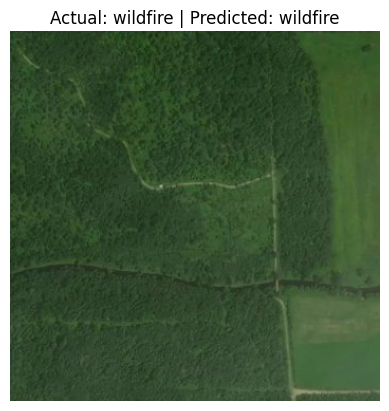

Actual: wildfire | Predicted: wildfire


In [24]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F


# Ensure your testdataset and model are already loaded, and the same transform is used.
# testdataset = datasets.ImageFolder(root='content/dataset/test', transform=valtransforms)
# model = ... (loaded model, already in eval mode and moved to device)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the same transform used for validation and testing
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load the test dataset again in this cell
test_dataset = datasets.ImageFolder(root="/content/dataset/test", transform=val_transforms)


# --- Specify the path to the image you want to test ---
# Replace this with the actual path to your image file
# img_path = "/content/dataset/test/wildfire/wildfire_0001.jpg" # Example path, change this


# Select a random sample from the test dataset
idx = random.randint(0, len(test_dataset) - 1)
image, label = test_dataset[idx] # Get image tensor and actual label
img_path, actual_label_idx = test_dataset.samples[idx] # Get image path and actual label index


# Display the original image (before transform)
orig_image = Image.open(img_path).convert('RGB')

# Prepare image for the model
input_tensor = image.unsqueeze(0).to(device)  # Add batch dimension and move to GPU if available

# Run prediction
with torch.no_grad():
    output = model(input_tensor)
    _, pred = torch.max(output, 1)

# Assuming your model was trained on the dataset with classes ['nowildfire', 'wildfire']
classes = test_dataset.classes  # Make sure this matches your model's class order
predicted_class = classes[pred.item()]
actual_class = classes[actual_label_idx]


# Display image and prediction
plt.imshow(orig_image)
plt.axis('off')
plt.title(f'Actual: {actual_class} | Predicted: {predicted_class}')
plt.show()
print(f'Actual: {actual_class} | Predicted: {predicted_class}')

In [20]:
# Save the model to Google Drive
save_path = "/content/drive/MyDrive/FDIPproject/wildfire_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved at: {save_path}")


Model saved at: /content/drive/MyDrive/FDIPproject/wildfire_model.pth
